# Use Cases

In [1]:
import numpy as np
import pandas as pd

from lets_plot import *


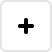
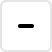
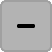
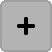
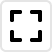
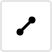
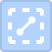
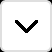
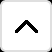
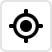
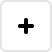
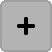
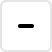
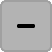
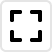
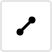
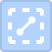
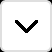
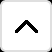
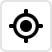

In [2]:
LetsPlot.setup_html()

## 1. [Issue #1288](https://github.com/JetBrains/lets-plot/issues/1288) - Allow absolute width for `geom_errorbar` (and possibly others)

In [3]:
def get_data1(n, seed=42):
    np.random.seed(seed)
    return pd.DataFrame({
        'x': np.random.choice(list("ABCDEFGHIJKLMNOP"), size=n),
        'y': np.random.normal(size=n),
    })

In [4]:
df1 = get_data1(100)
print(df1.shape)
df1.head()

(100, 2)


,x,y
0,G,0.738467
1,D,0.171368
2,M,-0.115648
3,O,-0.301104
4,K,-1.478522


In [5]:
subdf1 = df1[df1['x'].isin(['A', 'B', 'C', 'D'])].reset_index(drop=True)
print(subdf1.shape)
subdf1.head()

(24, 2)


,x,y
0,D,0.171368
1,C,0.324084
2,D,-0.839218
3,C,0.975545
4,B,-1.106335


### Current Situation

In [6]:
gggrid([
    ggplot(df1, aes('x', 'y')) + geom_errorbar(stat='summary', width=.5),
    ggplot(subdf1, aes('x', 'y')) + geom_errorbar(stat='summary', width=.5)
])

**Problem:** Both plots have `width=.5`, but visually the whisker widths are wider in the second plot.

### Expected Behavior

Do something so that with the same value of the `width` parameter it gets such plots:

In [7]:
gggrid([
    ggplot(df1, aes('x', 'y')) + geom_errorbar(stat='summary', width=.5),
    ggplot(subdf1, aes('x', 'y')) + geom_errorbar(stat='summary', width=.125)
])

## 2. Custom `width` with `'identity'` stat

In [8]:
def get_data2(n, shift=2, scalex=1, scaley=1, seed=42):
    np.random.seed(seed)
    return pd.DataFrame({
        'x': list(np.random.normal(loc=-shift, scale=scalex, size=n)) +
             list(np.random.normal(loc=shift, scale=scalex, size=n)),
        'y': list(np.random.normal(loc=-shift, scale=scaley, size=n)) +
             list(np.random.normal(loc=shift, scale=scaley, size=n)),
        'v': np.random.uniform(size=2*n),
    })

In [9]:
df2 = get_data2(5, shift=4, scaley=.2)
print(df2.shape)
df2.head()

(10, 3)


,x,y,v
0,-3.503286,-4.092684,0.456070
1,-4.138264,-4.093146,0.785176
2,-3.352311,-3.951608,0.199674
3,-2.476970,-4.382656,0.514234
4,-4.234153,-4.344984,0.592415


In [10]:
def get_aggdata2(df, binwidth):
    startx, starty = df['x'].min(), df['y'].min()
    binsx, binsy = int((df['x'].max() - df['x'].min()) / binwidth[0]) + 1, int((df['y'].max() - df['y'].min()) / binwidth[1]) + 1
    data = {'x': [], 'y': [], 'mean': []}
    for ix in range(binsx):
        for iy in range(binsy):
            centerx = startx + binwidth[0] / 2.0 + ix * binwidth[0]
            centery = starty + binwidth[1] / 2.0 + iy * binwidth[1]
            subdf = df[(df['x'] >= centerx - binwidth[0] / 2.0)&
                       (df['x'] < centerx + binwidth[0] / 2.0)&
                       (df['y'] >= centery - binwidth[1] / 2.0)&
                       (df['y'] < centery + binwidth[1] / 2.0)]
            if subdf.shape[0] == 0:
                continue
            data['x'].append(centerx)
            data['y'].append(centery)
            data['mean'].append(subdf['v'].mean())
    return pd.DataFrame(data)

In [11]:
aggdf2 = get_aggdata2(df2, [2, 2])
print(aggdf2.shape)
aggdf2.head()

(3, 3)


,x,y,mean
0,-3.234153,-3.382656,0.509514
1,2.765847,4.617344,0.065052
2,4.765847,4.617344,0.443351


In [12]:
ggplot() + \
    geom_tile(aes('x', 'y', fill='mean'), data=aggdf2, stat='identity') + \
    geom_point(aes('x', 'y'), data=df2, color="red")

**The reason for the strangely stretched tiles:** The vertical component of the `binwidth` parameter is much smaller than the actual gaps in the data due to their irregularity, while the height of the tiles is determined by the resolution.

Actually, it would be better to make the size of the tiles to match `binwidth=[2, 2]`, but the size is controlled by the `width`/`height` parameters with relative values that have nothing to do with coordinates:

In [13]:
# height=.25 - a value chosen by eye so that the height is about 2 y-axis units
ggplot() + \
    geom_tile(aes('x', 'y', fill='mean'), data=aggdf2, stat='identity', height=.25) + \
    geom_point(aes('x', 'y'), data=df2, color="red")